In [1]:


import pandas as pd
import os, time
import shutil
import sys
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import random
#Hyper params
split = 0.8
height, width = 224,224

train_df = pd.read_csv(r'D:\New folder (2)\NYU V2\nyu_data\data\nyu2_train.csv',header=None)
test = pd.read_csv(r'D:\New folder (2)\NYU V2\nyu_data\data\nyu2_test.csv',header=None).rename(columns={0:'image', 1:'depth'})
train_df = train_df.sample(frac=1).reset_index(drop=True).rename(columns={0:'image', 1:'depth'})
base_path = r'E:/Deep Learning/MDE/NYU V2/nyu_data'
train_df['image'] = train_df['image'].map(lambda x:os.path.join(base_path,x))
train_df['depth'] = train_df['depth'].map(lambda x:os.path.join(base_path,x))
test['image'] = test['image'].map(lambda x:os.path.join(base_path,x))
test['depth'] = test['depth'].map(lambda x:os.path.join(base_path,x))

train_df.head()
test.head()

print(train_df.shape,test.shape)
train_df=train_df[:500]
print(train_df.shape)


(50688, 2) (654, 2)
(500, 2)


(654, 2)
<class 'numpy.ndarray'>
100 25 81
(4, 224, 224, 3) (4, 224, 224, 1)


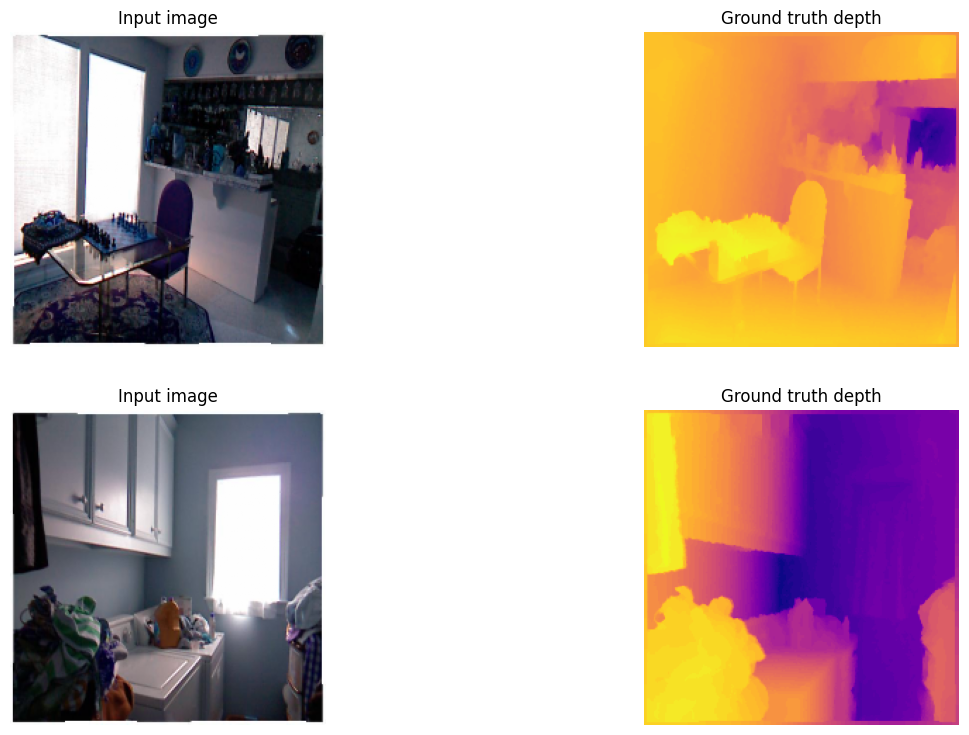

In [2]:


train_split = int(len(train_df)*split)
train = train_df[:train_split]
validation = train_df[train_split:]
len(train), len(validation)

print(test.shape)
# train_df.head()
print(type(train_df['image'].unique()))
dd=train_df.set_index('image')['depth'].to_dict()
# dd
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, shuffle=False, dim=(224, 224)):
        np.random.seed(43)
        self.df = dataframe
        self.height, self.width = dim
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.ids = dataframe['image'].unique()
        self.imgtodpth = dataframe.set_index('image')['depth'].to_dict()
        self.on_epoch_end()

    def __len__(self):
        return len(self.df) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_data(self, indexes):
        query_imgs = [self.ids[idx] for idx in indexes]
        target_imgs = [self.imgtodpth[img] for img in query_imgs]

        processed_query_img = []
        processed_depth_img = []

        for img_path, depth_path in zip(query_imgs, target_imgs):
            # Preprocess the image
            read_img = cv2.imread(img_path)
            resized_img = cv2.resize(read_img, (224,224)).astype(np.float32)
            scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
            flip = np.random.choice([True, False])
            if flip:
                scaled_img = cv2.flip(scaled_img, 1)
            processed_query_img.append(scaled_img)

            # Preprocess the depth map
            resized_img = cv2.resize(cv2.cvtColor(cv2.imread(depth_path), cv2.COLOR_BGR2GRAY), (224, 224)).astype(np.float32)
            scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
            if flip:
                scaled_img = cv2.flip(scaled_img, 1)
            scaled_img = np.expand_dims(scaled_img, axis=-1)
            processed_depth_img.append(scaled_img)

        return np.array(processed_query_img), np.array(processed_depth_img)

    def __getitem__(self, index):
        idxs = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        return self.load_data(idxs)
train_generator = DataGenerator(train, batch_size=4, shuffle=True, dim=(224,224))
val_generator = DataGenerator(validation, batch_size=4, shuffle=False, dim=(224,224))
test_generator = DataGenerator(test, batch_size=8, shuffle=False, dim=(224,224))
print(len(train_generator), len(val_generator), len(test_generator))
images,depths = next(iter(val_generator))
print(images.shape, depths.shape)

cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,4,2):
    image = images[i]
    depth = depths[i].squeeze(-1)
    plt.subplot(221+i)
    plt.axis('off')
    plt.imshow(image)
    plt.title('Input image')
    plt.subplot(222+i)
    plt.axis('off')
    plt.imshow(depth,cmap=plt.get_cmap(cmap))
    plt.title('Ground truth depth')


In [3]:
# Define the data generators
train_generator = DataGenerator(train, batch_size=4, shuffle=True, dim=(224,224))
val_generator = DataGenerator(validation, batch_size=4, shuffle=False, dim=(224,224))
test_generator = DataGenerator(test, batch_size=8, shuffle=False, dim=(224,224))

# Print the shapes of the images and depths
images, depths = next(iter(train_generator))
print("Train Images shape:", images.shape)
print("Train Depths shape:", depths.shape)

images, depths = next(iter(val_generator))
print("Validation Images shape:", images.shape)
print("Validation Depths shape:", depths.shape)

images, depths = next(iter(test_generator))
print("Test Images shape:", images.shape)
print("Test Depths shape:", depths.shape)


Train Images shape: (4, 224, 224, 3)
Train Depths shape: (4, 224, 224, 1)
Validation Images shape: (4, 224, 224, 3)
Validation Depths shape: (4, 224, 224, 1)
Test Images shape: (8, 224, 224, 3)
Test Depths shape: (8, 224, 224, 1)


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/25


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - loss: 1.1928 - ssim_loss: 0.5086 - val_loss: 1.0501 - val_ssim_loss: 0.3655
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - loss: 1.0543 - ssim_loss: 0.3746 - val_loss: 1.0432 - val_ssim_loss: 0.3628
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - loss: 1.0560 - ssim_loss: 0.3828 - val_loss: 1.0295 - val_ssim_loss: 0.3590
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - loss: 1.0203 - ssim_loss: 0.3672 - val_loss: 1.0044 - val_ssim_loss: 0.3472
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - loss: 0.9975 - ssim_loss: 0.3473 - val_loss: 0.9718 - val_ssim_loss: 0.3295
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - loss: 1.0013 - ssim_loss: 0.3535 - val_loss: 0.9718 - val_ssim_loss: 0.3299
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - loss: 0.9835 - ssim_loss: 0.3439 - val_loss: 0.9643 - val_ssim_loss: 0.3233
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - loss: 0.9903 - ssim_loss: 0.3455 - val_

81/81 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - loss: 1.0436 - ssim_loss: 0.3865
Test Loss: 1.0219327211380005
Test SSIM: 0.37790539860725403
81/81 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step


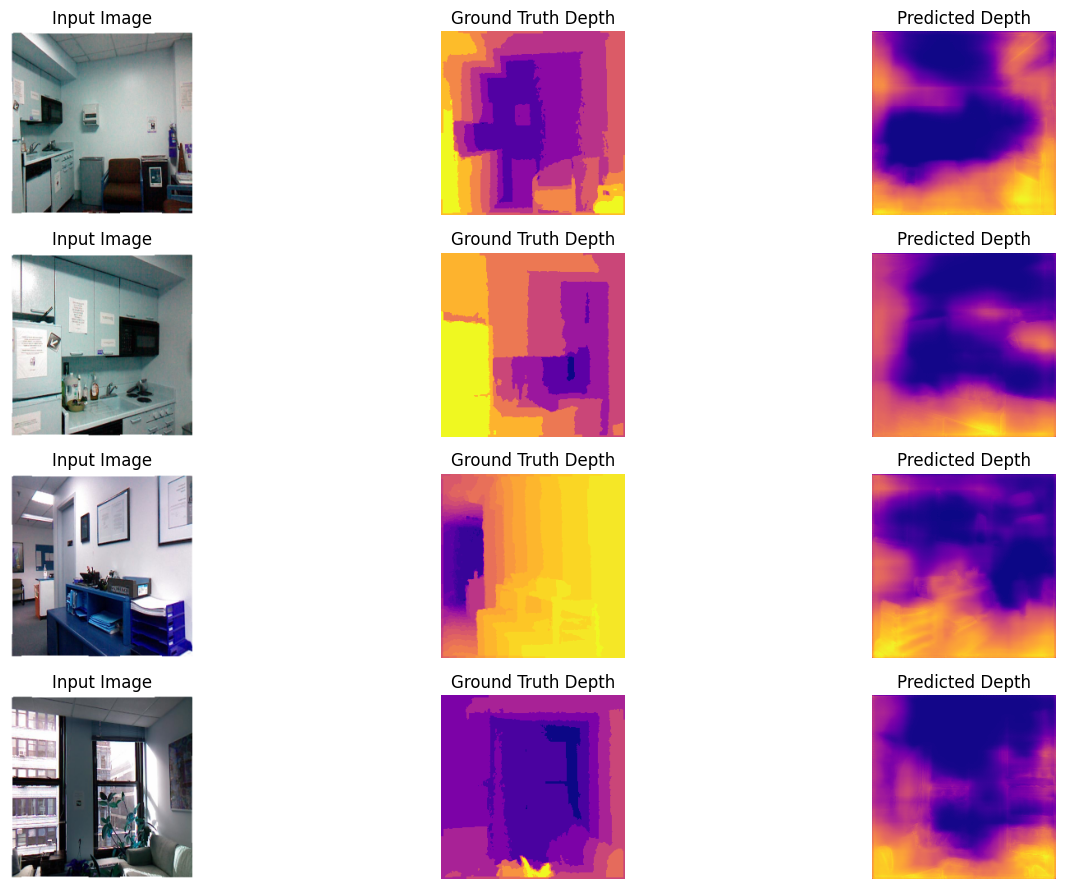

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import matplotlib.pyplot as plt

# Define the SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Define the combined loss function
def combined_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + ssim_loss(y_true, y_pred)

# Define the Residual Block
def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), padding='same'):
    res = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    res = BatchNormalization()(res)
    res = LeakyReLU(alpha=0.1)(res)
    res = Conv2D(filters, kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization()(res)
    res = LeakyReLU(alpha=0.1)(res)
    res = tf.keras.layers.add([res, x])
    return res

# Define the Attention Block
def attention_block(x, g, inter_channel_ratio=8):
    theta = Conv2D(filters=g.shape[-1]//inter_channel_ratio, kernel_size=1, strides=(1, 1), padding='same')(x)
    phi = Conv2D(filters=g.shape[-1]//inter_channel_ratio, kernel_size=1, strides=(1, 1), padding='same')(g)
    theta_phi = Activation('relu')(tf.keras.layers.add([theta, phi]))
    psi = Conv2D(filters=1, kernel_size=1, strides=(1, 1), padding='same')(theta_phi)
    psi = Activation('sigmoid')(psi)
    return tf.keras.layers.multiply([x, psi])

# Build the ResUNet with Attention Block
def build_resunet_with_attention(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    conv1 = residual_block(conv1, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    conv2 = residual_block(conv2, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, padding='same')(pool2)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    conv3 = residual_block(conv3, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bridge
    conv4 = Conv2D(512, 3, padding='same')(pool3)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    conv4 = residual_block(conv4, 512)
    
    # Decoder with attention
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    up5 = Conv2D(256, 3, padding='same')(up5)
    up5 = LeakyReLU(alpha=0.1)(up5)
    up5 = residual_block(up5, 256)
    up5 = attention_block(up5, conv3)
    
    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(up5)
    up6 = concatenate([up6, conv2], axis=3)
    up6 = Conv2D(128, 3, padding='same')(up6)
    up6 = LeakyReLU(alpha=0.1)(up6)
    up6 = residual_block(up6, 128)
    up6 = attention_block(up6, conv2)
    
    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(up6)
    up7 = concatenate([up7, conv1], axis=3)
    up7 = Conv2D(64, 3, padding='same')(up7)
    up7 = LeakyReLU(alpha=0.1)(up7)
    up7 = residual_block(up7, 64)
    up7 = attention_block(up7, conv1)
    
    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up7)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Define model parameters
input_shape = (224, 224, 3)

# Build the model
model = build_resunet_with_attention(input_shape)

# Compile the model with Adam optimizer and custom loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss=combined_loss, metrics=[ssim_loss])

# Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=25)  # Increased epochs for better training

# Save the trained model
model.save('resunet_with_attention.h5')

# Evaluate the model on test data
test_loss, test_ssim = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test SSIM:", test_ssim)

# Predict depth maps for the first four samples from the test set
predicted_depths = model.predict(test_generator)

# Load a batch from test_generator for visualization
test_images, test_depths = next(iter(test_generator))

# Plot the first four sample images with their predicted and ground truth depth maps
plt.figure(figsize=(15, 9))
for i in range(4):  # Visualizing only the first four samples
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(test_images[i])
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(test_depths[i].squeeze(-1), cmap=plt.get_cmap('plasma_r'))
    plt.title('Ground Truth Depth')
    plt.axis('off')

    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(predicted_depths[i].squeeze(-1), cmap=plt.get_cmap('plasma_r'))
    plt.title('Predicted Depth')
    plt.axis('off')

plt.tight_layout()
plt.show()
